Script to impute metacells using seacells package from AnnData object
https://github.com/dpeerlab/SEACells/blob/main/notebooks/SEACell_computation.ipynb

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

In [5]:
# Load the data using 
ad = sc.read('ss8.h5ad')
print(ad)

AnnData object with n_obs × n_vars = 7409 × 174742
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'stage', 'clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'scHelper_cell_type_new', 'scHelper_cell_type_old', 'rna_stage', 'rna_run', 'rna_clusters', 'ReadsInPeaks', 'FRIP', 'leiden'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'distToGeneStart', 'nearestGene', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N', 'name'
    uns: 'GeneScoresColums', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'GeneScores', 'X_svd', 'X_umap'
    obsp: 'connectivities', 'distances'


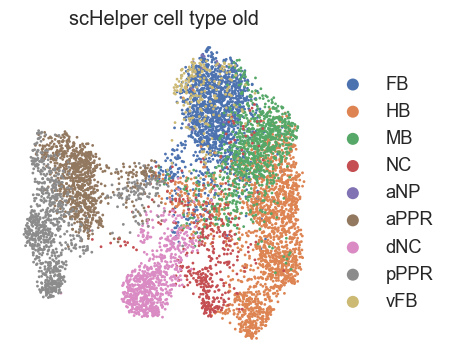

In [6]:
# Plot cell-types for reference
sc.pl.scatter(ad, basis='umap', color='scHelper_cell_type_old', frameon=False)

Preprocessing - for ATAC says to follow the prep-processing-ATAC.ipynb but cant seem to find that... the ArchR script is the one I followed to export the data into python

* TO DO: full check for any ATAC preprocessing script and check in paper what preprocessing needs to be run on ATAC data

Running SEACells - recommends one metacell for every 75 single cells
Their test dataset has ~7000 cells so picked 90 metacells, I have 7409 so can also do 90 for now


In [10]:
## User defined parameters

## Core parameters 
n_SEACells = 90
build_kernel_on = 'X_svd' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [11]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

In [12]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7409 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/7409 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7409 [00:00<?, ?it/s]

Constructing CSR matrix...


/Users/hamrude/miniconda3/envs/seacells_env_yaml/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


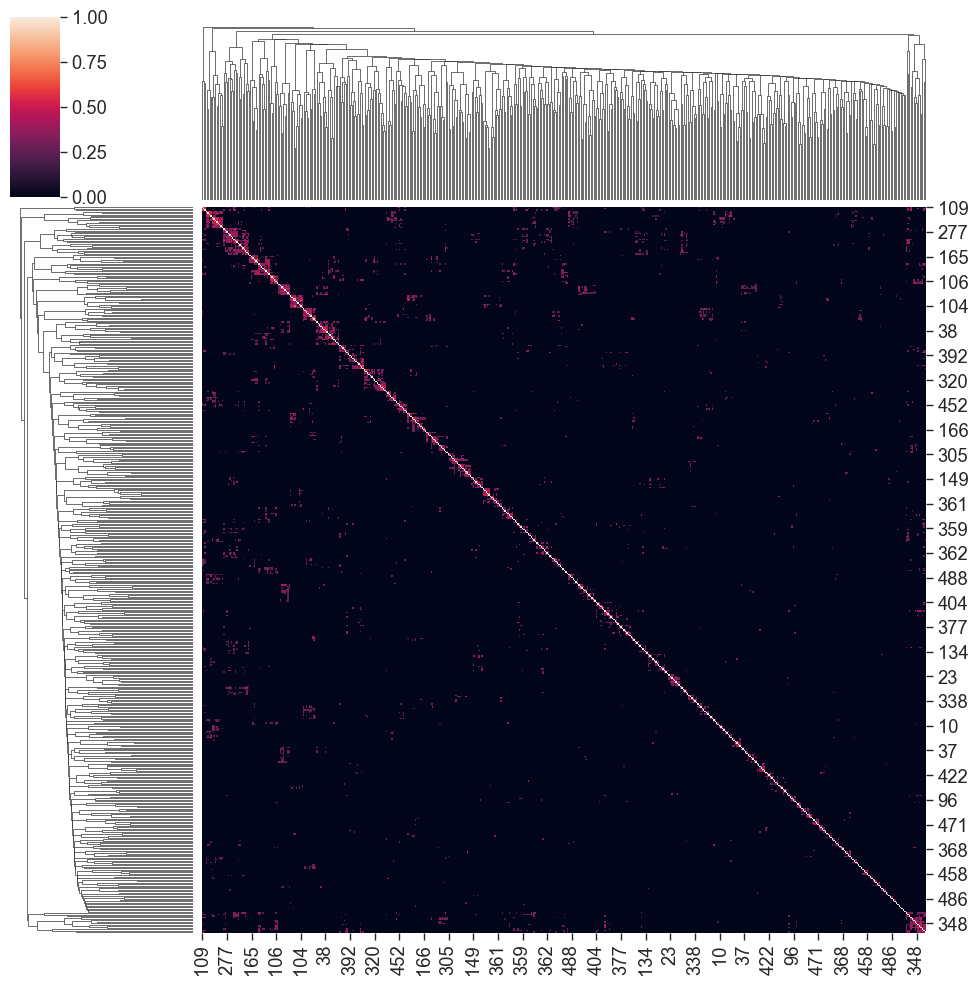

In [13]:
sns.clustermap(M.toarray()[:500,:500])

In [14]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Determing nearest neighbor graph...


/Users/hamrude/miniconda3/envs/seacells_env_yaml/lib/python3.8/site-packages/palantir/utils.py:57: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


Done.
Sampling waypoints ...
Done.
Selecting 88 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 124.66it/s]

Selecting 2 cells from greedy initialization.


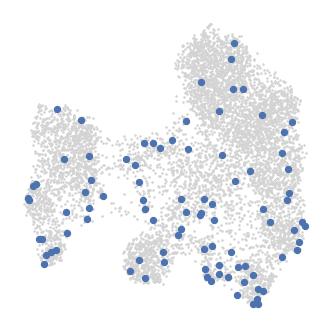

In [15]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ad, model)

In [16]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00154
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 34 iterations.


In [17]:
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 35 iterations
Ran for 40 iterations


***Accessing Results

*Model Convergence


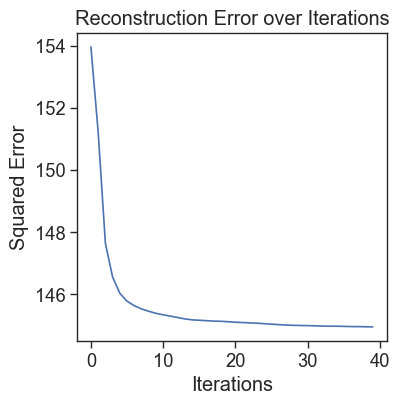

In [18]:
# Check for convergence 
model.plot_convergence()

* SEACell Hard Assignments
Can be accessed in the modified anndata object in .obs['SEACell'] // from the model using .get_hard_assignments()

In [19]:
ad.obs[['SEACell']].head()

,SEACell
index,
sample-ss8#CTCAGAACACTGCTCT-1,sample-ss8#GCCATAAGTCTGTGTA-1
sample-ss8#ACAGACTTCCAGGGAA-1,sample-ss8#GCTTGCTGTGTAGGAC-1
sample-ss8#GGTCATAAGGTAAGTT-1,sample-ss8#TTGCTTACATTACACG-1
sample-ss8#CATTCCGCAACAACTC-1,sample-ss8#CGGTGCACAATCACTG-1
sample-ss8#CACCTGTGTCAGAAGC-1,sample-ss8#AATACGCCATCATCGA-1


In [20]:
model.get_hard_assignments().head()

,SEACell
index,
sample-ss8#CTCAGAACACTGCTCT-1,sample-ss8#GCCATAAGTCTGTGTA-1
sample-ss8#ACAGACTTCCAGGGAA-1,sample-ss8#GCTTGCTGTGTAGGAC-1
sample-ss8#GGTCATAAGGTAAGTT-1,sample-ss8#TTGCTTACATTACACG-1
sample-ss8#CATTCCGCAACAACTC-1,sample-ss8#CGGTGCACAATCACTG-1
sample-ss8#CACCTGTGTCAGAAGC-1,sample-ss8#AATACGCCATCATCGA-1


* SEACell Soft Assignments
Full assignment matrix can be accessed in param model.A_
However most single cells are assigned to no more than 4 archetypes so just need to return top 5 metacell assignments and the corresponding weights in the function
model.get_soft_assignments()

/var/folders/8d/sqc39h513q7c8gp009fvbv1j1q6xhd/T/ipykernel_24097/2761727437.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)


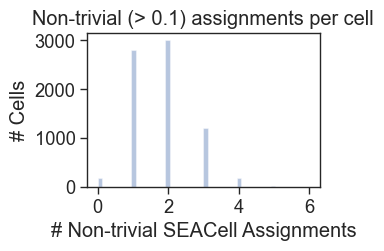

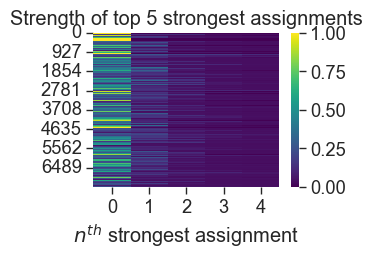

In [21]:
plt.figure(figsize=(3,2))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
plt.title(f'Non-trivial (> 0.1) assignments per cell')
plt.xlabel('# Non-trivial SEACell Assignments')
plt.ylabel('# Cells')
plt.show()

plt.figure(figsize=(3,2))
b = np.partition(model.A_.T, -5)    
sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
plt.title('Strength of top 5 strongest assignments')
plt.xlabel('$n^{th}$ strongest assignment')
plt.show()

In [22]:
labels,weights = model.get_soft_assignments()

In [26]:
labels.head()

,0,1,2,3,4
index,,,,,
sample-ss8#CTCAGAACACTGCTCT-1,sample-ss8#GCCATAAGTCTGTGTA-1,sample-ss8#AATACGCCATCATCGA-1,sample-ss8#TAGCCGGTCGATTACG-1,sample-ss8#CTTTGCGAGCACCATT-1,sample-ss8#TGGCGCACAAGCGAAC-1
sample-ss8#ACAGACTTCCAGGGAA-1,sample-ss8#GCTTGCTGTGTAGGAC-1,sample-ss8#TAGCCGGTCGATTACG-1,sample-ss8#CTTTGCGAGCACCATT-1,sample-ss8#TGGCGCACAAGCGAAC-1,sample-ss8#CGGTGCACAATCACTG-1
sample-ss8#GGTCATAAGGTAAGTT-1,sample-ss8#TTGCTTACATTACACG-1,sample-ss8#CGGTGCACAATCACTG-1,sample-ss8#TGATCAGCAGAACAGC-1,sample-ss8#TAGCCGGTCGATTACG-1,sample-ss8#CTTTGCGAGCACCATT-1
sample-ss8#CATTCCGCAACAACTC-1,sample-ss8#CGGTGCACAATCACTG-1,sample-ss8#AACAAAGTCCCGTATC-1,sample-ss8#CGCTATCCAGCGCGTT-1,sample-ss8#AGTTACGTCGCTTCAC-1,sample-ss8#CCACAGGTCACGATTG-1
sample-ss8#CACCTGTGTCAGAAGC-1,sample-ss8#AATACGCCATCATCGA-1,sample-ss8#GCCATAAGTCTGTGTA-1,sample-ss8#CTCTCAGCATAGAATG-1,sample-ss8#TAGCCGGTCGATTACG-1,sample-ss8#CTTTGCGAGCACCATT-1


Summarizing Data
Datasets can be summarised by aggregating cells within each SEACell ie summing over all raw data for all cells beloning to a SEACell. Output is an anndata object of n_metacells x original_data_dimension (nPeaks?). Data is unnormalized and raw aggregated counts are stored in X. 

In [32]:
# summarising needs to be run on a layer so copy the matrix to a layer called raw
ad.layers["raw"] = ad.X
ad.layers.keys()

Help on function summarize_by_SEACell in module SEACells.core:

summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
    Aggregates cells within each SEACell, summing over all raw data for all cells belonging to a SEACell.
    Data is unnormalized and raw aggregated counts are stored .layers['raw'].
    Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be
    manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.
    The output of this function is an anndata object of shape n_metacells x original_data_dimension.
    :return: anndata.AnnData containing aggregated counts.



In [43]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad

100%|█████████████████████████████████████████████████████████████████████████| 90/90 [00:04<00:00, 19.35it/s]


AnnData object with n_obs × n_vars = 90 × 174742
    layers: 'raw'

In [49]:
SEACell_ad.obs.head()

""
sample-ss8#GCCATAAGTCTGTGTA-1
sample-ss8#GCTTGCTGTGTAGGAC-1
sample-ss8#TTGCTTACATTACACG-1
sample-ss8#CGGTGCACAATCACTG-1
sample-ss8#AATACGCCATCATCGA-1


In [48]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ad, model.A_, celltype_label='scHelper_cell_type_old',summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

100%|█████████████████████████████████████████████████████████████████████████| 90/90 [25:00<00:00, 16.67s/it]


AnnData object with n_obs × n_vars = 90 × 174742
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

In [50]:
SEACell_soft_ad.obs.head()

,Pseudo-sizes,celltype,celltype_purity
0,78.572522,HB,0.980846
1,38.534527,pPPR,1.000000
2,71.988854,pPPR,0.907280
3,39.409456,HB,0.541558
4,156.670398,FB,0.584728


Evaluating Results
Visualizing results - see metacell assignments on 2D embedding and see distribution of number of cells assigned to each metacell

/Users/hamrude/miniconda3/envs/seacells_env_yaml/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/Users/hamrude/miniconda3/envs/seacells_env_yaml/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


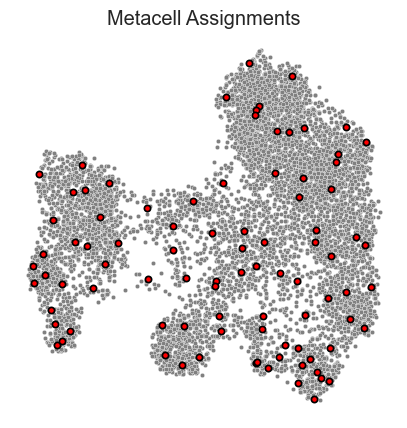

In [51]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)

/Users/hamrude/miniconda3/envs/seacells_env_yaml/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/Users/hamrude/miniconda3/envs/seacells_env_yaml/lib/python3.8/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


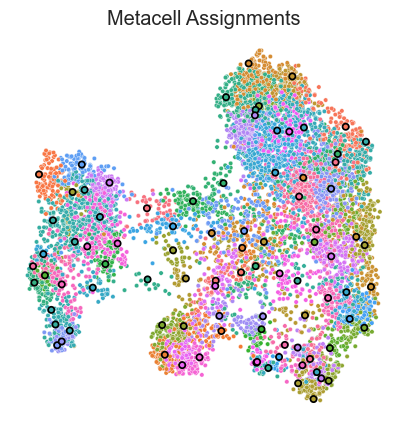

In [52]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

/Users/hamrude/miniconda3/envs/seacells_env_yaml/lib/python3.8/site-packages/SEACells/plot.py:120: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


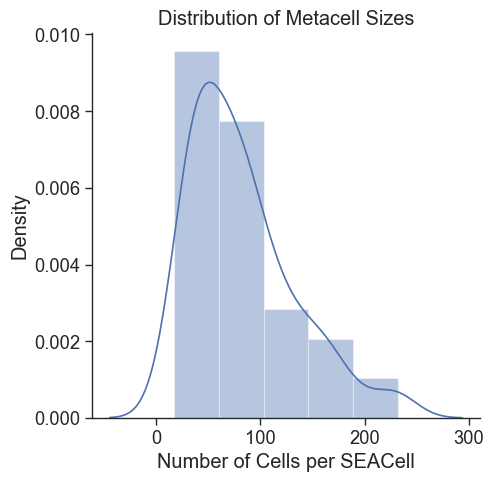

,size
SEACell,
sample-ss8#AACAAAGTCCCGTATC-1,55
sample-ss8#AACTGGTAGAGTAAGG-1,42
sample-ss8#AAGATAGAGTGATCTC-1,46
sample-ss8#AATACGCCATCATCGA-1,160
sample-ss8#AATACGCCATTTGGTG-1,91
...,...
sample-ss8#TTCGCGTTCGGTTAGT-1,30
sample-ss8#TTGCACCCAGACCTGC-1,19
sample-ss8#TTGCTTACATTACACG-1,54


In [53]:
SEACells.plot.plot_SEACell_sizes(ad, bins=5)

Quantifying results
- compute purity of different labels within a SEACell metacell
- compute per-SEACell variance in diffusion components
- compute diffusion distance between a SEACell and its nth neighbour

In [56]:
ad.obs

,Sample,TSSEnrichment,ReadsInTSS,ReadsInPromoter,PromoterRatio,PassQC,NucleosomeRatio,nMultiFrags,nMonoFrags,nFrags,...,predictedScore_Un,scHelper_cell_type_new,scHelper_cell_type_old,rna_stage,rna_run,rna_clusters,ReadsInPeaks,FRIP,leiden,SEACell
index,,,,,,,,,,,,,,,,,,,,,
sample-ss8#CTCAGAACACTGCTCT-1,sample-ss8,6.442,2661,14893,0.205676,1,1.265503,7502,15981,36205,...,0.630859,HB,HB,ss8,1,5,37865,0.522925,1,sample-ss8#GCCATAAGTCTGTGTA-1
sample-ss8#ACAGACTTCCAGGGAA-1,sample-ss8,5.997,2344,13421,0.185450,1,1.137709,6305,16927,36185,...,0.552403,aPPR,aPPR,ss8,1,9,36324,0.501921,8,sample-ss8#GCTTGCTGTGTAGGAC-1
sample-ss8#GGTCATAAGGTAAGTT-1,sample-ss8,7.234,2656,14566,0.201310,1,1.121504,7023,17053,36178,...,0.860273,dNC,dNC,ss8,1,1,37825,0.522762,3,sample-ss8#TTGCTTACATTACACG-1
sample-ss8#CATTCCGCAACAACTC-1,sample-ss8,7.223,2579,14351,0.198427,1,1.437614,7244,14835,36162,...,0.632240,HB,HB,ss8,1,5,38378,0.530640,3,sample-ss8#CGGTGCACAATCACTG-1
sample-ss8#CACCTGTGTCAGAAGC-1,sample-ss8,6.471,2549,14577,0.201674,1,1.605812,8863,13869,36140,...,0.629910,MB,MB,ss8,1,2,36378,0.503293,1,sample-ss8#AATACGCCATCATCGA-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sample-ss8#CTGGGACAGGCAGATC-1,sample-ss8,7.129,72,368,0.182540,1,1.863636,285,352,1008,...,0.739739,FB,FB,ss8,1,0,1003,0.497520,0,sample-ss8#TGTTAGGCAGGTAGCA-1
sample-ss8#GGAACTTCAATGGTAA-1,sample-ss8,5.033,61,385,0.190972,1,1.186551,233,461,1008,...,0.901085,pPPR,pPPR,ss8,1,6,1051,0.521329,6,sample-ss8#ATTGTCTTCGAGGCTC-1
sample-ss8#TTGCACCCACTCGGAC-1,sample-ss8,6.371,74,384,0.191235,1,1.256180,180,445,1004,...,0.875472,NC,NC,ss8,1,4,1053,0.524402,10,sample-ss8#TTGCACCCAGACCTGC-1


In [59]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'scHelper_cell_type_old')
SEACell_purity.head()

,scHelper_cell_type_old,scHelper_cell_type_old_purity
SEACell,,
sample-ss8#AACAAAGTCCCGTATC-1,MB,0.272727
sample-ss8#AACTGGTAGAGTAAGG-1,pPPR,0.976190
sample-ss8#AAGATAGAGTGATCTC-1,HB,1.000000
sample-ss8#AATACGCCATCATCGA-1,MB,0.643750
sample-ss8#AATACGCCATTTGGTG-1,dNC,1.000000


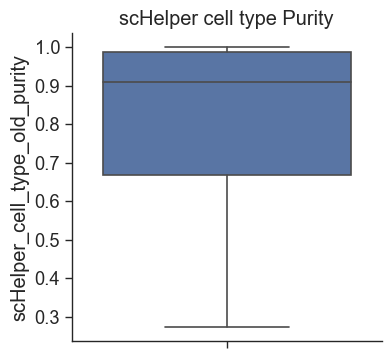

In [60]:
plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='scHelper_cell_type_old_purity')
plt.title('scHelper cell type Purity')
sns.despine()
plt.show()
plt.close()

In [61]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'clusters')
SEACell_purity.head()

,clusters,clusters_purity
SEACell,,
sample-ss8#AACAAAGTCCCGTATC-1,C8,0.945455
sample-ss8#AACTGGTAGAGTAAGG-1,C2,1.000000
sample-ss8#AAGATAGAGTGATCTC-1,C10,0.543478
sample-ss8#AATACGCCATCATCGA-1,C4,0.825000
sample-ss8#AATACGCCATTTGGTG-1,C3,1.000000


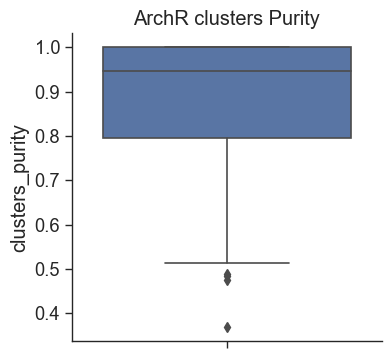

In [62]:
plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='clusters_purity')
plt.title('ArchR clusters Purity')
sns.despine()
plt.show()
plt.close()

Determing nearest neighbor graph...


/Users/hamrude/miniconda3/envs/seacells_env_yaml/lib/python3.8/site-packages/palantir/utils.py:57: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


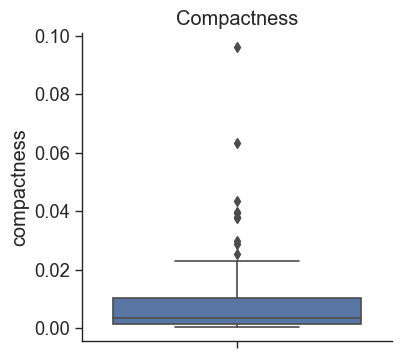

,compactness
SEACell,
sample-ss8#AACAAAGTCCCGTATC-1,0.007124
sample-ss8#AACTGGTAGAGTAAGG-1,0.001969
sample-ss8#AAGATAGAGTGATCTC-1,0.005814
sample-ss8#AATACGCCATCATCGA-1,0.002121
sample-ss8#AATACGCCATTTGGTG-1,0.001981


In [64]:
compactness = SEACells.evaluate.compactness(ad, 'X_svd')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

Determing nearest neighbor graph...


/Users/hamrude/miniconda3/envs/seacells_env_yaml/lib/python3.8/site-packages/palantir/utils.py:57: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


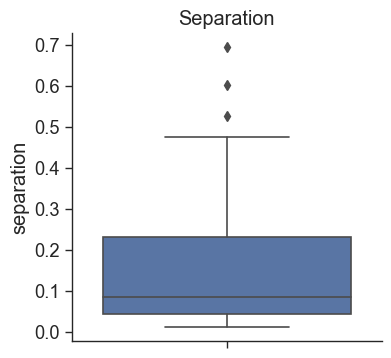

,separation
SEACell,
sample-ss8#AACAAAGTCCCGTATC-1,0.139640
sample-ss8#AACTGGTAGAGTAAGG-1,0.020115
sample-ss8#AAGATAGAGTGATCTC-1,0.299498
sample-ss8#AATACGCCATCATCGA-1,0.066972
sample-ss8#AATACGCCATTTGGTG-1,0.013320


In [65]:
separation = SEACells.evaluate.separation(ad, 'X_svd',nth_nbr=1)

plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()